<a href="https://colab.research.google.com/github/susanjax/Project_Genetic_Algorithm/blob/main/part_3_LGBM_model_optimization_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 20.2 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 210 kB 44.0 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 147 kB 49.0 MB/s 
     |████████████████████████████████| 112 kB 45.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=19cd4fa623fe04ed474552c5404d9c1f2fadd82638d259e84e91bee5ef5f3125
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import optuna
import lightgbm
from optuna.integration.lightgbm import LightGBMPruningCallback
from sklearn import metrics
import warnings
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
df = pd.read_csv('/content/drive/MyDrive/toxicity_project/data/transformed/scaled_original_material_cell.csv')

In [4]:
df

,Unnamed: 0,tissue,cell line,disease,material,morphology,cell type,organism,test,amw,...,mcd,CrippenClogP,Valance_electron,chi1v,chi2v,electronegativity,Zeta potential (mV),kappa1,chi0v,viability (%)
0,0,4.0,0.0,11.0,2.0,8.0,1.0,0.0,10.0,0.841234,...,-0.869413,0.578770,-0.453121,-0.776045,-0.251567,-0.038464,-0.018609,-0.202007,-0.266858,36.126
1,1,4.0,0.0,11.0,2.0,8.0,1.0,0.0,10.0,0.841234,...,-0.869413,0.578770,-0.453121,-0.776045,-0.251567,-0.038464,-0.836725,-0.202007,-0.266858,22.253
2,2,4.0,0.0,11.0,2.0,8.0,1.0,0.0,10.0,0.841234,...,-0.869413,0.578770,-0.453121,-0.776045,-0.251567,-0.038464,-0.778818,-0.202007,-0.266858,19.643
3,3,4.0,0.0,11.0,2.0,8.0,1.0,0.0,10.0,0.841234,...,-0.869413,0.578770,-0.453121,-0.776045,-0.251567,-0.038464,-0.369475,-0.202007,-0.266858,91.262
4,4,4.0,0.0,11.0,2.0,8.0,1.0,0.0,10.0,0.841234,...,-0.869413,0.578770,-0.453121,-0.776045,-0.251567,-0.038464,0.954115,-0.202007,-0.266858,87.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,3111,5.0,73.0,2.0,6.0,11.0,0.0,4.0,10.0,0.546648,...,0.639724,0.059492,-0.084818,1.580465,-0.251567,0.374527,-1.041253,-0.103262,0.825563,63.246
3025,3112,5.0,73.0,2.0,6.0,11.0,0.0,4.0,10.0,0.546648,...,0.639724,0.059492,-0.084818,1.580465,-0.251567,0.374527,-0.114170,-0.103262,0.825563,102.630
3026,3113,5.0,73.0,2.0,6.0,11.0,0.0,4.0,10.0,0.546648,...,0.639724,0.059492,-0.084818,1.580465,-0.251567,0.374527,1.009170,-0.103262,0.825563,107.880
3027,3114,5.0,73.0,2.0,6.0,11.0,0.0,4.0,10.0,0.546648,...,0.639724,0.059492,-0.084818,1.580465,-0.251567,0.374527,-0.134709,-0.103262,0.825563,106.440


In [5]:
X = df.drop(['viability (%)', 'material', 'Unnamed: 0'], axis=1) 
Y = df[['viability (%)']].copy()

In [6]:
X.columns

Index(['tissue', 'cell line', 'disease', 'morphology', 'cell type', 'organism',
       'test', 'amw', 'lipinskiHBD', 'CrippenMR', 'NumRotatableBonds',
       'Hydrodynamic diameter (nm)', 'hallKierAlpha', 'radii', 'lipinskiHBA',
       'concentration (ug/ml)', 'rox', 'labuteASA', 'NumHBA', 'mcd',
       'CrippenClogP', 'Valance_electron', 'chi1v', 'chi2v',
       'electronegativity', 'Zeta potential (mV)', 'kappa1', 'chi0v'],
      dtype='object')

In [7]:
cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
for idx, (train_indices, test_indices) in enumerate(cv.split(X, X[['amw']])):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]


In [8]:
# out_result()    

In [9]:
random_state = 42
def objective(trial, x, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.152),
        "num_leaves": trial.suggest_int("num_leaves", 2, 30),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 8, 20, step=1),
        "lambda_l1": trial.suggest_int("lambda_l1", 1,10),
        "lambda_l2": trial.suggest_int("lambda_l2", 1, 10),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.75, 1, step=0.01
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.65, 1, step=0.01
        ),
    }
    cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.2)

    cv_scores = np.empty(10)
    for idx, (train_indices, test_indices) in enumerate(cv.split(x, x[['amw']])):
        x_train, x_test = x.iloc[train_indices], x.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]


        model =lightgbm.LGBMRegressor(**param_grid)

        model.fit(x_train, y_train,)
        # model.fit(x_train, y_train,
        #           eval_set=[(x_test, y_test)],
        #           early_stopping_rounds=300,
        #           eval_metric= 'rmse',
        #           callbacks=[
        #               LightGBMPruningCallback(trial, metric="rmse")
        #           ])
        # print('x', x_test)
        pred_train = model.predict(x_train)
        # print('training',r2_score(y_train, pred_train))
        preds = model.predict(x_test)
        # print('prediction',preds)
        cv_scores[idx] = r2_score(y_test, preds)
        print('r2:', idx, cv_scores)
        print('mean and std', np.mean(cv_scores), np.std(cv_scores))
        print('MAE_test:', metrics.mean_absolute_error(y_test, preds))
        print('MSE_test:', metrics.mean_squared_error(y_test, preds))
        print('RMSE_test:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
        print('r2_train:', metrics.r2_score(y_train, pred_train))
        print('MAE_train:', metrics.mean_absolute_error(y_train, pred_train))
        print('MSE_train:', metrics.mean_squared_error(y_train, pred_train))
        print('RMSE_train:', np.sqrt(metrics.mean_squared_error(y_train, pred_train)))

    return np.mean(cv_scores)


study = optuna.create_study(direction="maximize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, Y)
study.optimize(func, n_trials=10)

print(f"\tBest value (r2): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2022-12-23 15:47:13,364] A new study created in memory with name: LGBM Regressor


r2: 0 [7.0603729e-001 1.4945486e-320 1.4950426e-320 1.4955367e-320
 1.4960308e-320]
mean and std 0.14120745807612384 0.2824149161522477
MAE_test: 11.423169941761298
MSE_test: 263.63705902221534
RMSE_test: 16.236904231478835
r2_train: 0.8529512311801656
MAE_train: 8.201092129993025
MSE_train: 127.07218438535581
RMSE_train: 11.272629878841752
r2: 1 [7.06037290e-001 6.97900508e-001 1.49504264e-320 1.49553671e-320
 1.49603078e-320]
mean and std 0.2807875596854436 0.3439027496747227
MAE_test: 11.497010878321115
MSE_test: 262.33290398849994
RMSE_test: 16.19669423025884
r2_train: 0.8518612090835994
MAE_train: 8.212925279871193
MSE_train: 129.10760210816957
RMSE_train: 11.362552622899909
r2: 2 [7.06037290e-001 6.97900508e-001 7.19405290e-001 1.49553671e-320
 1.49603078e-320]
mean and std 0.42466861777373904 0.3468084692868971
MAE_test: 11.750529776218682
MSE_test: 267.42082815040493
RMSE_test: 16.3530067006164
r2_train: 0.8494943674640545
MAE_train: 8.12589031567447
MSE_train: 127.844272606008

[I 2022-12-23 15:47:20,256] Trial 0 finished with value: 0.7212067050657003 and parameters: {'n_estimators': 739, 'learning_rate': 0.05106339445122306, 'num_leaves': 10, 'max_depth': 9, 'min_data_in_leaf': 10, 'lambda_l1': 7, 'lambda_l2': 6, 'bagging_fraction': 0.86, 'bagging_freq': 1, 'feature_fraction': 0.95}. Best is trial 0 with value: 0.7212067050657003.


r2: 4 [0.70603729 0.69790051 0.71940529 0.73202443 0.75066601]
mean and std 0.7212067050657003 0.01876917029189731
MAE_test: 11.174781617000916
MSE_test: 234.8287488605171
RMSE_test: 15.324123102498136
r2_train: 0.8432014061099901
MAE_train: 8.338956508306747
MSE_train: 133.69320542502305
RMSE_train: 11.562577801901401
r2: 0 [0.5593235  0.69790051 0.71940529 0.73202443 0.75066601]
mean and std 0.6918639473071057 0.06845799008043177
MAE_test: 14.620644513666
MSE_test: 387.4453216695467
RMSE_test: 19.683630805050846
r2_train: 0.6578207069809978
MAE_train: 12.811717626670283
MSE_train: 297.08037887616473
RMSE_train: 17.236019809577986
r2: 1 [0.5593235  0.57870809 0.71940529 0.73202443 0.75066601]
mean and std 0.6680254635956293 0.08168099362017014
MAE_test: 14.63357574824398
MSE_test: 364.21677967629233
RMSE_test: 19.084464353926528
r2_train: 0.6524440500519431
MAE_train: 13.02690914268921
MSE_train: 303.2478635592931
RMSE_train: 17.414013424805123
r2: 2 [0.5593235  0.57870809 0.59181041 

[I 2022-12-23 15:47:24,587] Trial 1 finished with value: 0.5688916423092717 and parameters: {'n_estimators': 255, 'learning_rate': 0.05723502250024313, 'num_leaves': 19, 'max_depth': 3, 'min_data_in_leaf': 14, 'lambda_l1': 7, 'lambda_l2': 2, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 0 with value: 0.7212067050657003.


r2: 4 [0.5593235  0.57870809 0.59181041 0.57781507 0.53680114]
mean and std 0.5688916423092717 0.01909245727508922
MAE_test: 15.475003590830466
MSE_test: 409.89563024058225
RMSE_test: 20.245879339771395
r2_train: 0.6633582096216304
MAE_train: 12.717134104712933
MSE_train: 292.0061632014179
RMSE_train: 17.088187826724575
r2: 0 [0.7761433  0.57870809 0.59181041 0.57781507 0.53680114]
mean and std 0.612255601359913 0.08400255221180593
MAE_test: 9.918520232797983
MSE_test: 204.61306393927256
RMSE_test: 14.304302287747996
r2_train: 0.9393382345782801
MAE_train: 4.614010411925093
MSE_train: 52.157345985077384
RMSE_train: 7.222004291405357
r2: 1 [0.7761433  0.70276145 0.59181041 0.57781507 0.53680114]
mean and std 0.6370662738572587 0.08862298797112446
MAE_test: 10.756155667282433
MSE_test: 251.62015717698097
RMSE_test: 15.862539430273483
r2_train: 0.9407040989214478
MAE_train: 4.621349044384146
MSE_train: 51.99163101243038
RMSE_train: 7.210522242697153
r2: 2 [0.7761433  0.70276145 0.75892914

[I 2022-12-23 15:47:46,651] Trial 2 finished with value: 0.7447423070685971 and parameters: {'n_estimators': 1204, 'learning_rate': 0.05650804230764776, 'num_leaves': 26, 'max_depth': 20, 'min_data_in_leaf': 8, 'lambda_l1': 3, 'lambda_l2': 9, 'bagging_fraction': 0.78, 'bagging_freq': 1, 'feature_fraction': 0.89}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.7761433  0.70276145 0.75892914 0.72303886 0.76283878]
mean and std 0.7447423070685971 0.027379562969487275
MAE_test: 9.954300162828202
MSE_test: 202.2534577260739
RMSE_test: 14.221584219983155
r2_train: 0.9375283141891435
MAE_train: 4.73294977306268
MSE_train: 54.684008044452256
RMSE_train: 7.394863625818414
r2: 0 [0.35864568 0.70276145 0.75892914 0.72303886 0.76283878]
mean and std 0.6612427831461203 0.1529522378266021
MAE_test: 18.538392195160522
MSE_test: 584.0187642133898
RMSE_test: 24.16648017840806
r2_train: 0.33965286563876185
MAE_train: 18.514529172390137
MSE_train: 568.4214831664112
RMSE_train: 23.84159145624325
r2: 1 [0.35864568 0.35332805 0.75892914 0.72303886 0.76283878]
mean and std 0.5913561018148592 0.19268569228289398
MAE_test: 18.05332098999144
MSE_test: 552.1205248435759
RMSE_test: 23.497245047953513
r2_train: 0.342795026886476
MAE_train: 18.618536242249295
MSE_train: 574.9129346562971
RMSE_train: 23.977342109923217
r2: 2 [0.35864568 0.35332805 0.33368285 0.7

[I 2022-12-23 15:47:47,990] Trial 3 finished with value: 0.3439854622745734 and parameters: {'n_estimators': 837, 'learning_rate': 0.02061179573125219, 'num_leaves': 2, 'max_depth': 29, 'min_data_in_leaf': 14, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.89, 'bagging_freq': 1, 'feature_fraction': 0.77}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.35864568 0.35332805 0.33368285 0.3115492  0.36272154]
mean and std 0.3439854622745734 0.019034188692186437
MAE_test: 17.54947873120473
MSE_test: 515.2642952437096
RMSE_test: 22.699433808879675
r2_train: 0.3405810329130461
MAE_train: 18.75669183540451
MSE_train: 584.5806693634122
RMSE_train: 24.178103096881117
r2: 0 [0.66384294 0.35332805 0.33368285 0.3115492  0.36272154]
mean and std 0.4050249139126043 0.1305957959798808
MAE_test: 10.928810139141428
MSE_test: 284.4970112264927
RMSE_test: 16.867039195617373
r2_train: 0.9611017925238055
MAE_train: 3.2546107807283495
MSE_train: 34.115061303017164
RMSE_train: 5.84080998689541
r2: 1 [0.66384294 0.74354443 0.33368285 0.3115492  0.36272154]
mean and std 0.48306819045998645 0.1826173265606375
MAE_test: 9.6202477285353
MSE_test: 220.45090174169408
RMSE_test: 14.84758908852525
r2_train: 0.9518050993394843
MAE_train: 3.4658603223316558
MSE_train: 42.06958282200222
RMSE_train: 6.486106907999761
r2: 2 [0.66384294 0.74354443 0.7844478  0.31

[I 2022-12-23 15:48:07,494] Trial 4 finished with value: 0.7272928991261027 and parameters: {'n_estimators': 2862, 'learning_rate': 0.10371539761147014, 'num_leaves': 27, 'max_depth': 13, 'min_data_in_leaf': 20, 'lambda_l1': 5, 'lambda_l2': 8, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.71}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.66384294 0.74354443 0.7844478  0.71880976 0.72581957]
mean and std 0.7272928991261027 0.039066167011373755
MAE_test: 10.120352406580517
MSE_test: 234.128176484066
RMSE_test: 15.301247546656645
r2_train: 0.9588602954683053
MAE_train: 3.344510678671024
MSE_train: 35.979586516480325
RMSE_train: 5.998298635153165
r2: 0 [0.74035526 0.74354443 0.7844478  0.71880976 0.72581957]
mean and std 0.7425953648448076 0.022824229324898207
MAE_test: 10.631649780570951
MSE_test: 232.8883957828015
RMSE_test: 15.26068136692466
r2_train: 0.8736716971876188
MAE_train: 7.4120365543785125
MSE_train: 109.19553315510248
RMSE_train: 10.449666652822112
r2: 1 [0.74035526 0.73020122 0.7844478  0.71880976 0.72581957]
mean and std 0.7399267231470918 0.02333166558558219
MAE_test: 11.252207053078942
MSE_test: 236.39647178433177
RMSE_test: 15.37519013815217
r2_train: 0.8754802710707565
MAE_train: 7.340701299106927
MSE_train: 108.28148774499962
RMSE_train: 10.405839117774194
r2: 2 [0.74035526 0.73020122 0.723110

[I 2022-12-23 15:48:11,958] Trial 5 finished with value: 0.7314456091148817 and parameters: {'n_estimators': 917, 'learning_rate': 0.04191956200245955, 'num_leaves': 15, 'max_depth': 30, 'min_data_in_leaf': 17, 'lambda_l1': 5, 'lambda_l2': 10, 'bagging_fraction': 0.98, 'bagging_freq': 1, 'feature_fraction': 0.76}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.74035526 0.73020122 0.72311005 0.6934645  0.77009701]
mean and std 0.7314456091148817 0.024847162091991698
MAE_test: 10.51939125976712
MSE_test: 198.50908291890042
RMSE_test: 14.089325140648164
r2_train: 0.8680168365809957
MAE_train: 7.579852823967562
MSE_train: 115.19175671610952
RMSE_train: 10.732742273813786
r2: 0 [0.73717593 0.73020122 0.72311005 0.6934645  0.77009701]
mean and std 0.7308097414554059 0.024650923957017477
MAE_test: 11.471381995972548
MSE_test: 258.0101051248269
RMSE_test: 16.062692959925087
r2_train: 0.8568214409090745
MAE_train: 7.850061611844188
MSE_train: 120.49889949234867
RMSE_train: 10.977199073185686
r2: 1 [0.73717593 0.72680007 0.72311005 0.6934645  0.77009701]
mean and std 0.7301295116230164 0.024705197265294968
MAE_test: 10.761983437281206
MSE_test: 238.13111359515418
RMSE_test: 15.431497451483903
r2_train: 0.8616226909887368
MAE_train: 7.82254182936909
MSE_train: 120.41678795321272
RMSE_train: 10.973458340614991
r2: 2 [0.73717593 0.72680007 0.707

[I 2022-12-23 15:48:13,037] Trial 6 finished with value: 0.7166967330411327 and parameters: {'n_estimators': 127, 'learning_rate': 0.13504920183088645, 'num_leaves': 25, 'max_depth': 27, 'min_data_in_leaf': 9, 'lambda_l1': 6, 'lambda_l2': 6, 'bagging_fraction': 0.9299999999999999, 'bagging_freq': 1, 'feature_fraction': 0.67}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.73717593 0.72680007 0.70737851 0.68908763 0.72304153]
mean and std 0.7166967330411327 0.016797755556846827
MAE_test: 11.259288279610157
MSE_test: 248.1862702697035
RMSE_test: 15.753928724915049
r2_train: 0.8663349342616885
MAE_train: 7.671183634272221
MSE_train: 115.55751569218907
RMSE_train: 10.749768169229933
r2: 0 [0.73677167 0.72680007 0.70737851 0.68908763 0.72304153]
mean and std 0.7166158823422732 0.016699677392396667
MAE_test: 10.309219653866826
MSE_test: 216.304120053166
RMSE_test: 14.707281191748732
r2_train: 0.921500257343312
MAE_train: 5.578587266901725
MSE_train: 69.27503356741384
RMSE_train: 8.323162473928635
r2: 1 [0.73677167 0.73647651 0.70737851 0.68908763 0.72304153]
mean and std 0.7185511712544101 0.018255938490849367
MAE_test: 10.144811829960949
MSE_test: 226.5331821408866
RMSE_test: 15.051019305711046
r2_train: 0.9212776561915921
MAE_train: 5.6749725479129065
MSE_train: 68.78132716601858
RMSE_train: 8.29345085992668
r2: 2 [0.73677167 0.73647651 0.74925874 

[I 2022-12-23 15:48:16,230] Trial 7 finished with value: 0.7440720855469061 and parameters: {'n_estimators': 622, 'learning_rate': 0.13749778468581458, 'num_leaves': 17, 'max_depth': 7, 'min_data_in_leaf': 20, 'lambda_l1': 6, 'lambda_l2': 9, 'bagging_fraction': 0.99, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.73677167 0.73647651 0.74925874 0.73914907 0.75870443]
mean and std 0.7440720855469061 0.008674466190568228
MAE_test: 10.265028438738828
MSE_test: 212.59164975764511
RMSE_test: 14.580522958990365
r2_train: 0.9165639705959703
MAE_train: 5.730285915039623
MSE_train: 72.44864305101622
RMSE_train: 8.511676864814373
r2: 0 [0.7608211  0.73647651 0.74925874 0.73914907 0.75870443]
mean and std 0.7488819720991422 0.009877149310589296
MAE_test: 10.517050674792054
MSE_test: 222.68198890104787
RMSE_test: 14.922532925111872
r2_train: 0.935415323496031
MAE_train: 4.856573477477674
MSE_train: 55.27529275623226
RMSE_train: 7.434735553887055
r2: 1 [0.7608211  0.73700305 0.74925874 0.73914907 0.75870443]
mean and std 0.7489872795913954 0.00974626400286957
MAE_test: 10.562106746801966
MSE_test: 239.77628203960063
RMSE_test: 15.48471123526689
r2_train: 0.9362363810553735
MAE_train: 4.8771227683189
MSE_train: 54.88027052770658
RMSE_train: 7.40812192986229
r2: 2 [0.7608211  0.73700305 0.74907784 0.7

[I 2022-12-23 15:48:24,641] Trial 8 finished with value: 0.7373774442172312 and parameters: {'n_estimators': 874, 'learning_rate': 0.08761798100163898, 'num_leaves': 22, 'max_depth': 10, 'min_data_in_leaf': 14, 'lambda_l1': 1, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.71}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.7608211  0.73700305 0.74907784 0.71164888 0.72833634]
mean and std 0.7373774442172312 0.016913576703903213
MAE_test: 10.745112565799161
MSE_test: 238.1894344086146
RMSE_test: 15.433387003785482
r2_train: 0.9335332678272865
MAE_train: 4.894843557739115
MSE_train: 57.7668491997032
RMSE_train: 7.600450591886195
r2: 0 [0.76808784 0.73700305 0.74907784 0.71164888 0.72833634]
mean and std 0.7388307920680196 0.019043674666238936
MAE_test: 10.256131441805135
MSE_test: 214.16170239699855
RMSE_test: 14.634264668817444
r2_train: 0.9067746855892164
MAE_train: 6.1225383121427175
MSE_train: 79.78572103898986
RMSE_train: 8.932285320061707
r2: 1 [0.76808784 0.73110088 0.74907784 0.71164888 0.72833634]
mean and std 0.7376503571745449 0.019301562274569247
MAE_test: 10.767305429612401
MSE_test: 246.13760695232438
RMSE_test: 15.688773277484902
r2_train: 0.9099448606548936
MAE_train: 6.041190536236249
MSE_train: 77.42954876905317
RMSE_train: 8.799406160023139
r2: 2 [0.76808784 0.73110088 0.7662999

[I 2022-12-23 15:48:26,686] Trial 9 finished with value: 0.7378680012466002 and parameters: {'n_estimators': 264, 'learning_rate': 0.13753448133410412, 'num_leaves': 22, 'max_depth': 17, 'min_data_in_leaf': 16, 'lambda_l1': 6, 'lambda_l2': 3, 'bagging_fraction': 0.77, 'bagging_freq': 1, 'feature_fraction': 0.98}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.76808784 0.73110088 0.76629995 0.70989811 0.71395322]
mean and std 0.7378680012466002 0.024986557951460608
MAE_test: 10.62065078103003
MSE_test: 246.0938069581846
RMSE_test: 15.687377312928525
r2_train: 0.9110490191829745
MAE_train: 6.091505950522629
MSE_train: 77.69930099384189
RMSE_train: 8.814720698572467
r2: 0 [0.64214706 0.73110088 0.76629995 0.70989811 0.71395322]
mean and std 0.7126798447092394 0.04049366278544778
MAE_test: 12.758701331388227
MSE_test: 295.2720149933035
RMSE_test: 17.183480875343722
r2_train: 0.7216946283750576
MAE_train: 11.754938509323777
MSE_train: 245.55247000730512
RMSE_train: 15.670113911752688
r2: 1 [0.64214706 0.64852684 0.76629995 0.70989811 0.71395322]
mean and std 0.6961650377155092 0.04606791191707703
MAE_test: 12.50026066429014
MSE_test: 278.6001462909129
RMSE_test: 16.69131948921094
r2_train: 0.7200136826445096
MAE_train: 11.885745053027934
MSE_train: 248.73717752200213
RMSE_train: 15.771403790468435
r2: 2 [0.64214706 0.64852684 0.64249075

[I 2022-12-23 15:48:42,771] Trial 10 finished with value: 0.6412591813499897 and parameters: {'n_estimators': 1842, 'learning_rate': 0.0019717490224820805, 'num_leaves': 30, 'max_depth': 22, 'min_data_in_leaf': 11, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.89}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.64214706 0.64852684 0.64249075 0.64748154 0.62564971]
mean and std 0.6412591813499897 0.00821580468601524
MAE_test: 13.389093370278198
MSE_test: 310.0705453391286
RMSE_test: 17.608820100708865
r2_train: 0.7233644266375643
MAE_train: 11.672597280833303
MSE_train: 243.87455330713632
RMSE_train: 15.61648338478085
r2: 0 [0.75582565 0.8        0.825      0.89       1.005     ]
mean and std 0.8551651303908514 0.08658569739866753
MAE_test: 10.26598422761371
MSE_test: 225.10717421066988
RMSE_test: 15.003572048371344
r2_train: 0.9349382976986889
MAE_train: 4.762044531109803
MSE_train: 55.83149376641567
RMSE_train: 7.472047494925047
r2: 1 [0.75582565 0.71304612 0.825      0.89       1.005     ]
mean and std 0.837774353905601 0.10308039738896738
MAE_test: 10.547502859924197
MSE_test: 251.16753975494547
RMSE_test: 15.848266143491706
r2_train: 0.9401079695463271
MAE_train: 4.678933717142495
MSE_train: 52.06676341989192
RMSE_train: 7.215730276270858
r2: 2 [0.75582565 0.71304612 0.74599906 0

[I 2022-12-23 15:48:49,880] Trial 11 finished with value: 0.7339440149728367 and parameters: {'n_estimators': 1715, 'learning_rate': 0.1077002799197728, 'num_leaves': 13, 'max_depth': 19, 'min_data_in_leaf': 20, 'lambda_l1': 3, 'lambda_l2': 10, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'feature_fraction': 0.8400000000000001}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.75582565 0.71304612 0.74599906 0.75304947 0.70179978]
mean and std 0.7339440149728367 0.022177115523828998
MAE_test: 10.841165533253744
MSE_test: 270.3184002510402
RMSE_test: 16.44136248159015
r2_train: 0.935760040065754
MAE_train: 4.753944826450911
MSE_train: 55.37499002735711
RMSE_train: 7.4414373629935975
r2: 0 [0.63788584 0.8        0.825      0.89       1.005     ]
mean and std 0.8315771679711343 0.120037838395995
MAE_test: 12.966678583297282
MSE_test: 312.4075841632886
RMSE_test: 17.67505542178832
r2_train: 0.7199108472853613
MAE_train: 11.71885166860657
MSE_train: 244.49901532934658
RMSE_train: 15.63646428478467
r2: 1 [0.63788584 0.63776957 0.825      0.89       1.005     ]
mean and std 0.799131082868757 0.1437678244922443
MAE_test: 12.941485278338595
MSE_test: 287.7203461590751
RMSE_test: 16.962321367049828
r2_train: 0.7216552391587047
MAE_train: 11.85798247209737
MSE_train: 247.57373899897408
RMSE_train: 15.734476127249172
r2: 2 [0.63788584 0.63776957 0.63677492 0.89 

[I 2022-12-23 15:48:52,733] Trial 12 finished with value: 0.6361872354631167 and parameters: {'n_estimators': 1278, 'learning_rate': 0.07476461178907993, 'num_leaves': 8, 'max_depth': 2, 'min_data_in_leaf': 8, 'lambda_l1': 10, 'lambda_l2': 8, 'bagging_fraction': 0.81, 'bagging_freq': 1, 'feature_fraction': 0.87}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.63788584 0.63776957 0.63677492 0.63796731 0.63053853]
mean and std 0.6361872354631167 0.002856954261633091
MAE_test: 13.583045691287182
MSE_test: 325.68524612013084
RMSE_test: 18.046751677798717
r2_train: 0.7222761144525083
MAE_train: 11.649629151697273
MSE_train: 241.13500695248993
RMSE_train: 15.528522368612215
r2: 0 [0.68592462 0.8        0.825      0.89       1.005     ]
mean and std 0.8411849238995972 0.10514961022619271
MAE_test: 10.614613659406244
MSE_test: 277.073477736191
RMSE_test: 16.645524255372404
r2_train: 0.9523448634363646
MAE_train: 3.518869663529513
MSE_train: 41.3069269969985
RMSE_train: 6.42704652208139
r2: 1 [0.68592462 0.69567301 0.825      0.89       1.005     ]
mean and std 0.8203195256149638 0.12048476913701818
MAE_test: 10.236712183685551
MSE_test: 240.90964178831487
RMSE_test: 15.52126418138403
r2_train: 0.9560911260070133
MAE_train: 3.3908946406874914
MSE_train: 39.102091151844846
RMSE_train: 6.253166490014866
r2: 2 [0.68592462 0.69567301 0.69841396

[I 2022-12-23 15:49:05,749] Trial 13 finished with value: 0.7151591954225223 and parameters: {'n_estimators': 2161, 'learning_rate': 0.15074761255980446, 'num_leaves': 18, 'max_depth': 22, 'min_data_in_leaf': 12, 'lambda_l1': 3, 'lambda_l2': 9, 'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.68592462 0.69567301 0.69841396 0.7296415  0.7661429 ]
mean and std 0.7151591954225223 0.029406971067699586
MAE_test: 10.168960161584932
MSE_test: 224.61359080409284
RMSE_test: 14.987114158639509
r2_train: 0.9556678931753021
MAE_train: 3.373596642529239
MSE_train: 37.616297176580645
RMSE_train: 6.133212630961089
r2: 0 [0.70619118 0.8        0.825      0.89       1.005     ]
mean and std 0.8452382364861041 0.09931525970556641
MAE_test: 10.495485731371764
MSE_test: 249.3771357133394
RMSE_test: 15.791679318974895
r2_train: 0.9537552157071814
MAE_train: 3.763165365248334
MSE_train: 40.501250855568244
RMSE_train: 6.364059306415069
r2: 1 [0.70619118 0.74814402 0.825      0.89       1.005     ]
mean and std 0.8348670402287034 0.10598168198087049
MAE_test: 10.21342270991557
MSE_test: 235.51346981836593
RMSE_test: 15.346448117345131
r2_train: 0.9486764815057401
MAE_train: 3.8243857079650305
MSE_train: 43.87303481561892
RMSE_train: 6.623672305875263
r2: 2 [0.70619118 0.74814402 0.7433299

[I 2022-12-23 15:49:15,694] Trial 14 finished with value: 0.7302258147256383 and parameters: {'n_estimators': 1320, 'learning_rate': 0.11251707317070331, 'num_leaves': 30, 'max_depth': 7, 'min_data_in_leaf': 17, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.8200000000000001, 'bagging_freq': 1, 'feature_fraction': 0.81}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.70619118 0.74814402 0.74332996 0.73353953 0.71992438]
mean and std 0.7302258147256383 0.015411322946261696
MAE_test: 10.952115329299058
MSE_test: 266.5143153613374
RMSE_test: 16.325266165099343
r2_train: 0.9572196082861701
MAE_train: 3.6003074479485773
MSE_train: 36.320913557557574
RMSE_train: 6.026683462532072
r2: 0 [0.75248127 0.8        0.825      0.89       1.005     ]
mean and std 0.8544962539993485 0.08735996932384406
MAE_test: 10.155512818608367
MSE_test: 234.06813632953114
RMSE_test: 15.299285484280995
r2_train: 0.951777340688304
MAE_train: 3.780403482896306
MSE_train: 41.09033776785167
RMSE_train: 6.410174550497956
r2: 1 [0.75248127 0.73054067 0.825      0.89       1.005     ]
mean and std 0.8406043870043269 0.09958819979929437
MAE_test: 10.089869005397604
MSE_test: 231.36868480404493
RMSE_test: 15.21080815749265
r2_train: 0.9518872374659886
MAE_train: 3.809330517020457
MSE_train: 42.046047919875164
RMSE_train: 6.484292399319695
r2: 2 [0.75248127 0.73054067 0.71572601

[I 2022-12-23 15:49:32,810] Trial 15 finished with value: 0.7331879819588257 and parameters: {'n_estimators': 2363, 'learning_rate': 0.07472667957736391, 'num_leaves': 22, 'max_depth': 14, 'min_data_in_leaf': 12, 'lambda_l1': 9, 'lambda_l2': 8, 'bagging_fraction': 0.94, 'bagging_freq': 1, 'feature_fraction': 0.8200000000000001}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.75248127 0.73054067 0.71572601 0.75827239 0.70891958]
mean and std 0.7331879819588257 0.019505604571011446
MAE_test: 10.723913473581414
MSE_test: 237.44483589324727
RMSE_test: 15.40924514352495
r2_train: 0.9522470463718752
MAE_train: 3.760175446198459
MSE_train: 42.22810519798765
RMSE_train: 6.498315566205418
r2: 0 [0.59808432 0.8        0.825      0.89       1.005     ]
mean and std 0.8236168630075514 0.13321498620064084
MAE_test: 13.70034550403686
MSE_test: 331.45771804507956
RMSE_test: 18.205980282453332
r2_train: 0.7101818439634631
MAE_train: 11.891683467044803
MSE_train: 255.72095163981854
RMSE_train: 15.991277361105915
r2: 1 [0.59808432 0.60828536 0.825      0.89       1.005     ]
mean and std 0.7852739350139413 0.1594930481632243
MAE_test: 13.863731270900638
MSE_test: 352.0201350964364
RMSE_test: 18.76219963374328
r2_train: 0.7055595504624326
MAE_train: 11.880603279809431
MSE_train: 254.36260675849678
RMSE_train: 15.948749379136183
r2: 2 [0.59808432 0.60828536 0.5767907

[I 2022-12-23 15:49:34,847] Trial 16 finished with value: 0.6057690616614948 and parameters: {'n_estimators': 605, 'learning_rate': 0.03708587046865387, 'num_leaves': 6, 'max_depth': 23, 'min_data_in_leaf': 18, 'lambda_l1': 4, 'lambda_l2': 7, 'bagging_fraction': 0.78, 'bagging_freq': 1, 'feature_fraction': 0.93}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.59808432 0.60828536 0.57679071 0.61460272 0.63108221]
mean and std 0.6057690616614948 0.01802176979498879
MAE_test: 13.631119720845268
MSE_test: 323.4286813797135
RMSE_test: 17.984123036159243
r2_train: 0.7030699486549199
MAE_train: 12.002737734471776
MSE_train: 258.16140598716817
RMSE_train: 16.067401967560535
r2: 0 [0.73358715 0.8        0.825      0.89       1.005     ]
mean and std 0.8507174290106665 0.0919775834373868
MAE_test: 10.183609293335538
MSE_test: 238.58860870192385
RMSE_test: 15.446313757719796
r2_train: 0.9472446054660063
MAE_train: 3.9010821344769893
MSE_train: 45.62015750821817
RMSE_train: 6.754269576217562
r2: 1 [0.73358715 0.74359831 0.825      0.89       1.005     ]
mean and std 0.8394370911612345 0.10056380766041292
MAE_test: 9.78396582829199
MSE_test: 219.15114357199204
RMSE_test: 14.8037543742117
r2_train: 0.9472501863676948
MAE_train: 4.0372314978064665
MSE_train: 46.154379146343075
RMSE_train: 6.793701431939961
r2: 2 [0.73358715 0.74359831 0.69424257 

[I 2022-12-23 15:49:44,168] Trial 17 finished with value: 0.7207041837034579 and parameters: {'n_estimators': 1230, 'learning_rate': 0.08676754810578881, 'num_leaves': 26, 'max_depth': 6, 'min_data_in_leaf': 8, 'lambda_l1': 1, 'lambda_l2': 4, 'bagging_fraction': 0.89, 'bagging_freq': 1, 'feature_fraction': 1.0}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.73358715 0.74359831 0.69424257 0.73859608 0.69349681]
mean and std 0.7207041837034579 0.022139060490078005
MAE_test: 11.122630672058374
MSE_test: 260.7033292156123
RMSE_test: 16.14631008049865
r2_train: 0.9519683854903609
MAE_train: 3.889169028065149
MSE_train: 42.07491203840021
RMSE_train: 6.486517712794763
r2: 0 [0.74030017 0.8        0.825      0.89       1.005     ]
mean and std 0.8520600332017715 0.09029156648737714
MAE_test: 11.05368658052741
MSE_test: 244.67964580641174
RMSE_test: 15.642239155773439
r2_train: 0.8965229656187015
MAE_train: 6.613387742819731
MSE_train: 88.27091561206856
RMSE_train: 9.395260273779996
r2: 1 [0.74030017 0.73078687 0.825      0.89       1.005     ]
mean and std 0.838217406398661 0.10178573312564242
MAE_test: 10.515492124049702
MSE_test: 231.10620812186434
RMSE_test: 15.202177742740162
r2_train: 0.897240637078469
MAE_train: 6.611170820284498
MSE_train: 89.81497827104678
RMSE_train: 9.477076462234901
r2: 2 [0.74030017 0.73078687 0.76507072 0.89

[I 2022-12-23 15:49:46,675] Trial 18 finished with value: 0.7294027086538557 and parameters: {'n_estimators': 516, 'learning_rate': 0.12320794857836866, 'num_leaves': 13, 'max_depth': 13, 'min_data_in_leaf': 19, 'lambda_l1': 3, 'lambda_l2': 9, 'bagging_fraction': 0.97, 'bagging_freq': 1, 'feature_fraction': 0.87}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.74030017 0.73078687 0.76507072 0.6793005  0.73155529]
mean and std 0.7294027086538557 0.027956187980362514
MAE_test: 10.575148864337189
MSE_test: 238.38812227627088
RMSE_test: 15.43982261155454
r2_train: 0.8992432533164216
MAE_train: 6.514743530461477
MSE_train: 87.30550112752717
RMSE_train: 9.34374128106762
r2: 0 [0.75051988 0.8        0.825      0.89       1.005     ]
mean and std 0.8541039753349853 0.08782036423178978
MAE_test: 9.995186581548184
MSE_test: 222.11871194344525
RMSE_test: 14.90364760531613
r2_train: 0.9183393810015434
MAE_train: 5.683002041337937
MSE_train: 70.71795459625991
RMSE_train: 8.409396803353967
r2: 1 [0.75051988 0.7379382  0.825      0.89       1.005     ]
mean and std 0.8416916145058387 0.09834530648441796
MAE_test: 9.839587812346993
MSE_test: 218.25541246223483
RMSE_test: 14.773469885650927
r2_train: 0.9206805734251652
MAE_train: 5.709365519173877
MSE_train: 69.82928794879976
RMSE_train: 8.356392041353718
r2: 2 [0.75051988 0.7379382  0.70705703 0.89

[I 2022-12-23 15:49:53,199] Trial 19 finished with value: 0.7395420471312963 and parameters: {'n_estimators': 1079, 'learning_rate': 0.061993949948298405, 'num_leaves': 19, 'max_depth': 17, 'min_data_in_leaf': 16, 'lambda_l1': 4, 'lambda_l2': 10, 'bagging_fraction': 0.84, 'bagging_freq': 1, 'feature_fraction': 0.79}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.75051988 0.7379382  0.70705703 0.73596605 0.76622909]
mean and std 0.7395420471312963 0.019510752520414704
MAE_test: 10.00833207611551
MSE_test: 212.89678945993182
RMSE_test: 14.590983156043043
r2_train: 0.9177528078956246
MAE_train: 5.7136123707541
MSE_train: 70.81065381497594
RMSE_train: 8.414906643271566
r2: 0 [0.70034803 0.8        0.825      0.89       1.005     ]
mean and std 0.8440696069578131 0.10096520478196513
MAE_test: 10.604195812687948
MSE_test: 256.40825457873575
RMSE_test: 16.012752873217515
r2_train: 0.9407468869106621
MAE_train: 4.601387421363815
MSE_train: 51.74296784817659
RMSE_train: 7.19325850002463
r2: 1 [0.70034803 0.74712203 0.825      0.89       1.005     ]
mean and std 0.8334940122249274 0.10758006320377342
MAE_test: 9.910276403992587
MSE_test: 211.9754535255868
RMSE_test: 14.559376824767838
r2_train: 0.9410102542656951
MAE_train: 4.624523766034472
MSE_train: 51.84044880753953
RMSE_train: 7.200031167122788
r2: 2 [0.70034803 0.74712203 0.74785249 0.89 

[I 2022-12-23 15:50:02,114] Trial 20 finished with value: 0.7361391568902939 and parameters: {'n_estimators': 1620, 'learning_rate': 0.0918515797775082, 'num_leaves': 16, 'max_depth': 25, 'min_data_in_leaf': 12, 'lambda_l1': 7, 'lambda_l2': 5, 'bagging_fraction': 0.78, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 2 with value: 0.7447423070685971.


r2: 4 [0.70034803 0.74712203 0.74785249 0.74453969 0.74083354]
mean and std 0.7361391568902939 0.018063423194157588
MAE_test: 10.437966518239024
MSE_test: 225.59856820682322
RMSE_test: 15.019939021408284
r2_train: 0.9372257879947147
MAE_train: 4.617329929770295
MSE_train: 54.67250400183534
RMSE_train: 7.394085744825748
r2: 0 [0.75654051 0.74712203 0.74785249 0.74453969 0.74083354]
mean and std 0.7473776525350379 0.005198620510157116
MAE_test: 10.230055019337948
MSE_test: 208.8670950606662
RMSE_test: 14.452234950368963
r2_train: 0.9199967287487752
MAE_train: 5.52516838679766
MSE_train: 69.9339212203181
RMSE_train: 8.362650370565428
r2: 1 [0.75654051 0.72678968 0.74785249 0.74453969 0.74083354]
mean and std 0.7433111839279439 0.00975957554246638
MAE_test: 10.153106781046318
MSE_test: 231.48788185401438
RMSE_test: 15.214725822505457
r2_train: 0.9240660862855766
MAE_train: 5.476772819922522
MSE_train: 66.57159427938784
RMSE_train: 8.15914176120184
r2: 2 [0.75654051 0.72678968 0.75516824 0.

[I 2022-12-23 15:50:08,859] Trial 21 finished with value: 0.7460209216173233 and parameters: {'n_estimators': 1088, 'learning_rate': 0.06638681973458499, 'num_leaves': 19, 'max_depth': 19, 'min_data_in_leaf': 16, 'lambda_l1': 4, 'lambda_l2': 10, 'bagging_fraction': 0.84, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.7460209216173233.


r2: 4 [0.75654051 0.72678968 0.75516824 0.75489886 0.73670732]
mean and std 0.7460209216173233 0.012080866372881789
MAE_test: 10.600376626384003
MSE_test: 239.48845900080426
RMSE_test: 15.475414663291069
r2_train: 0.9258065955120227
MAE_train: 5.410861145990684
MSE_train: 63.89809753366355
RMSE_train: 7.993628558649918
r2: 0 [0.72500208 0.72678968 0.75516824 0.75489886 0.73670732]
mean and std 0.7397132353202664 0.013129599880276673
MAE_test: 10.646979489258925
MSE_test: 209.68476427388103
RMSE_test: 14.480495995437485
r2_train: 0.8497419432192226
MAE_train: 8.332318452905218
MSE_train: 134.88931368421788
RMSE_train: 11.614185881249615
r2: 1 [0.72500208 0.71618341 0.75516824 0.75489886 0.73670732]
mean and std 0.7375919804804788 0.015659296789367477
MAE_test: 11.074141129759502
MSE_test: 224.38630501907252
RMSE_test: 14.979529532634611
r2_train: 0.8470653346925263
MAE_train: 8.315912165843033
MSE_train: 136.23441362091452
RMSE_train: 11.671949863708056
r2: 2 [0.72500208 0.71618341 0.74

[I 2022-12-23 15:50:12,448] Trial 22 finished with value: 0.71801685203709 and parameters: {'n_estimators': 503, 'learning_rate': 0.028250000965460743, 'num_leaves': 24, 'max_depth': 19, 'min_data_in_leaf': 15, 'lambda_l1': 2, 'lambda_l2': 9, 'bagging_fraction': 0.83, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.7460209216173233.


r2: 4 [0.72500208 0.71618341 0.74123603 0.68228859 0.72537415]
mean and std 0.71801685203709 0.01960573267274265
MAE_test: 11.414099478444676
MSE_test: 243.75037748061214
RMSE_test: 15.612507085046019
r2_train: 0.8425617847799884
MAE_train: 8.332253799855613
MSE_train: 136.4555343076862
RMSE_train: 11.681418334589607
r2: 0 [0.75679834 0.71618341 0.74123603 0.68228859 0.72537415]
mean and std 0.7243761042893493 0.02519894408909602
MAE_test: 9.726722332792619
MSE_test: 191.47568241300056
RMSE_test: 13.837473845070154
r2_train: 0.9295879838911028
MAE_train: 5.198823185449019
MSE_train: 62.79284099191896
RMSE_train: 7.9241933969281035
r2: 1 [0.75679834 0.78057389 0.74123603 0.68228859 0.72537415]
mean and std 0.73725420054269 0.03297507545451781
MAE_test: 9.473728804245853
MSE_test: 200.2615816289474
RMSE_test: 14.151380908905937
r2_train: 0.9279173458537335
MAE_train: 5.135948725960287
MSE_train: 62.00191905359289
RMSE_train: 7.874129733093867
r2: 2 [0.75679834 0.78057389 0.71224141 0.682

[I 2022-12-23 15:50:20,859] Trial 23 finished with value: 0.743447564682375 and parameters: {'n_estimators': 1409, 'learning_rate': 0.06663195801887464, 'num_leaves': 20, 'max_depth': 20, 'min_data_in_leaf': 19, 'lambda_l1': 5, 'lambda_l2': 10, 'bagging_fraction': 0.88, 'bagging_freq': 1, 'feature_fraction': 0.73}. Best is trial 21 with value: 0.7460209216173233.


r2: 4 [0.75679834 0.78057389 0.71224141 0.72135082 0.74627336]
mean and std 0.743447564682375 0.024603588176254534
MAE_test: 10.182054190550032
MSE_test: 223.14387010061267
RMSE_test: 14.938000873631406
r2_train: 0.9289081675962064
MAE_train: 5.062610712339553
MSE_train: 61.76303407960913
RMSE_train: 7.858946117617116
r2: 0 [0.71357527 0.78057389 0.71224141 0.72135082 0.74627336]
mean and std 0.734802949340817 0.025950517649552165
MAE_test: 10.898993828823583
MSE_test: 248.6185185401032
RMSE_test: 15.767641502143027
r2_train: 0.8931960775780724
MAE_train: 6.80017763724656
MSE_train: 93.09365294113744
RMSE_train: 9.648505217967053
r2: 1 [0.71357527 0.74599438 0.71224141 0.72135082 0.74627336]
mean and std 0.727887047798322 0.015220167527357095
MAE_test: 10.28808266455117
MSE_test: 225.55880469749533
RMSE_test: 15.018615272304412
r2_train: 0.8905840475713003
MAE_train: 6.973876717855908
MSE_train: 94.77040358674195
RMSE_train: 9.735009172401531
r2: 2 [0.71357527 0.74599438 0.75460733 0.7

[I 2022-12-23 15:50:26,248] Trial 24 finished with value: 0.7321854519478082 and parameters: {'n_estimators': 1049, 'learning_rate': 0.047580775613661516, 'num_leaves': 14, 'max_depth': 15, 'min_data_in_leaf': 18, 'lambda_l1': 4, 'lambda_l2': 7, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8400000000000001}. Best is trial 21 with value: 0.7460209216173233.


r2: 4 [0.71357527 0.74599438 0.75460733 0.7356116  0.71113868]
mean and std 0.7321854519478082 0.017288556953822153
MAE_test: 10.848714588981387
MSE_test: 236.86935633274354
RMSE_test: 15.39056062438089
r2_train: 0.8922816650010764
MAE_train: 6.78370153192941
MSE_train: 95.13040956042836
RMSE_train: 9.753481919828856
	Best value (r2): 0.74602
	Best params:
		n_estimators: 1088
		learning_rate: 0.06638681973458499
		num_leaves: 19
		max_depth: 19
		min_data_in_leaf: 16
		lambda_l1: 4
		lambda_l2: 10
		bagging_fraction: 0.84
		bagging_freq: 1
		feature_fraction: 0.8


In [10]:
model = lightgbm.LGBMRegressor(n_estimators= 1713,
                      learning_rate= 0.10839344194316336,
                      num_leaves= 9,
                      max_depth=5,
                      min_data_in_leaf=11,
                      lambda_l1 = 7,
                      lambda_l2 = 6,
                      bagging_fraction=0.95,
                      bagging_freq=1,
                      feature_fraction=0.75,)
lgb_model = model.fit(X_train, Y_train)
# 46.5/62 in 92/71

In [11]:
model = lightgbm.LGBMRegressor(n_estimators= 1388,
                      learning_rate= 0.04677282863111515,
                      num_leaves= 17,
                      max_depth=13,
                      min_data_in_leaf=16,
                      lambda_l1 = 4,
                      lambda_l2 = 5,
                      bagging_fraction=0.89,
                      bagging_freq=1,
                      feature_fraction=0.82,)
lgb_model = model.fit(X_train, Y_train)
# 0.45/59 in 0.92/71

In [12]:
model = lightgbm.LGBMRegressor(n_estimators= 1398,
                      learning_rate= 0.14892450981116276,
                      num_leaves= 14,
                      max_depth=23,
                      min_data_in_leaf=8,
                      lambda_l1 = 1,
                      lambda_l2 = 9,
                      bagging_fraction=.98,
                      bagging_freq=1,
                      feature_fraction=0.68,)
lgb_model = model.fit(X_train, Y_train)
# 0.57/64 in 0.94/70

##save model into file

In [13]:
# import pickle
# pickle.dump(model, open('model.pkl', 'wb'))

##model evaluation in external set

In [14]:
train = model.predict(X_train)
# print(r2_score(Y_test, test))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, train))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_train, train)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_train, train))) 
print("Regressor R2-score: ", r2_score(Y_train, train))

Mean Absolute Error: 4.208830653811559
Mean Squared Error: 47.706649191301025
Root Mean Squared Error: 6.907000013848344
Regressor R2-score:  0.9459261546563376


In [15]:
test = model.predict(X_test)
# print(r2_score(Y_test, test))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, test))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, test)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, test))) 
print("Regressor R2-score: ", r2_score(Y_test, test))

Mean Absolute Error: 10.233230125297814
Mean Squared Error: 208.46386078977443
Root Mean Squared Error: 14.438277625457076
Regressor R2-score:  0.7474851204143476


In [16]:
dff = pd.read_csv('/content/drive/MyDrive/toxicity_project/data/transformed/scaled_external_material_cell.csv')

In [17]:
X_val = dff.drop(['viability (%)', 'material', 'Unnamed: 0'], axis=1) 
Y_val = dff[['viability (%)']].copy()

In [18]:
validation = model.predict(X_val)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_val, validation))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_val, validation))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_val, validation))) 
print("Regressor R2-score: ", r2_score(Y_val, validation))

Mean Absolute Error: 10.64126518694337
Mean Squared Error: 204.532024963566
Root Mean Squared Error: 14.301469328833523
Regressor R2-score:  0.6378449141297462


#Visualization

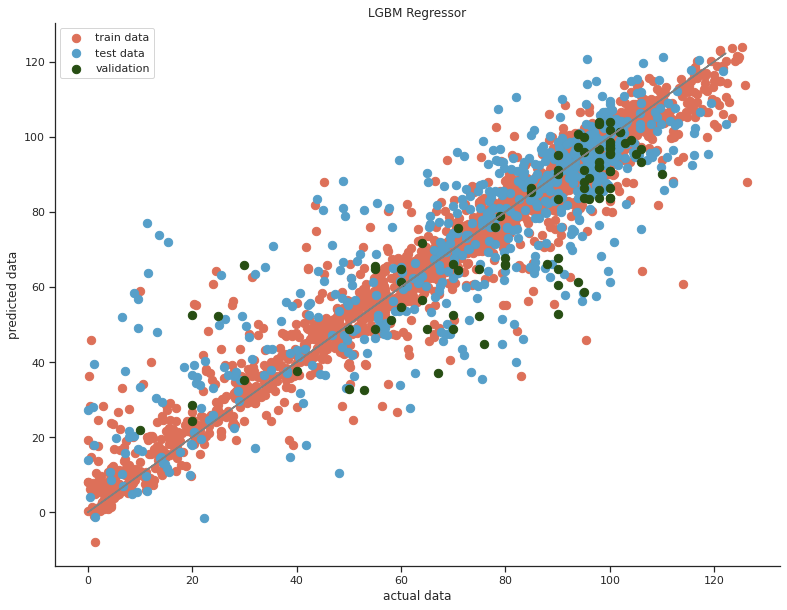

In [19]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
f, ax = plt.subplots(figsize=(13, 10))

plt.scatter(Y_train, train, color='#DD7059', s=70, label = 'train data')
plt.scatter(Y_test, test, color='#569FC9',s=70, label = 'test data')
plt.scatter(Y_val, validation, color='#274E13',s=70, label = 'validation')
plt.plot(Y_test, Y_test, color='gray')
plt.title('LGBM Regressor')
plt.xlabel('actual data')
plt.ylabel('predicted data')
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()
# ax.figure.savefig("LGBM_regressor_with_external_data.png",transparent=True)

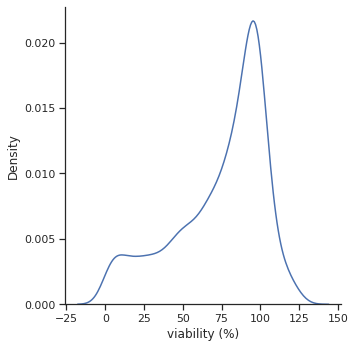

In [20]:
sns.displot(data = df, x='viability (%)', kind = 'kde')

# removing data for ZnO

In [21]:
X_val

,tissue,cell line,disease,morphology,cell type,organism,test,amw,lipinskiHBD,CrippenMR,...,NumHBA,mcd,CrippenClogP,Valance_electron,chi1v,chi2v,electronegativity,Zeta potential (mV),kappa1,chi0v
0,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
1,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
2,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
3,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
4,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,4.0,59.0,2.0,2.0,1.0,0.0,1.0,-0.528729,-0.150483,-0.529015,...,-0.143120,-0.003374,0.316370,-0.674102,0.413273,-0.251567,-0.022162,0.550477,-0.171844,0.620069
83,4.0,59.0,2.0,2.0,1.0,0.0,1.0,-0.528729,-0.150483,-0.529015,...,-0.143120,-0.003374,0.316370,-0.674102,0.413273,-0.251567,-0.022162,0.550477,-0.171844,0.620069
84,4.0,59.0,2.0,2.0,1.0,0.0,1.0,-0.528729,-0.150483,-0.529015,...,-0.143120,-0.003374,0.316370,-0.674102,0.413273,-0.251567,-0.022162,0.550477,-0.171844,0.620069
85,4.0,59.0,2.0,2.0,1.0,0.0,1.0,-0.528729,-0.150483,-0.529015,...,-0.143120,-0.003374,0.316370,-0.674102,0.413273,-0.251567,-0.022162,0.550477,-0.171844,0.620069


In [22]:
# specific_yval = Y_val[(Y_val['viability (%)']>=20) & (Y_val['viability (%)']<105)]
# specific_xval = X_val[X_val.index.isin(specific_yval.index)]

In [23]:
df2 = dff[dff.material != 17]
specific_xval = df2.drop(['viability (%)', 'Unnamed: 0', 'material'], axis=1) 
specific_yval =df2[['viability (%)']]

In [24]:
# specific_yval = specific_yval.dropna()
specific_yval

,viability (%)
0,100.0
1,96.0
2,90.0
3,60.0
4,40.0
5,30.0
6,20.0
7,100.0
8,88.0
9,76.0


In [25]:
specific_xval

,tissue,cell line,disease,morphology,cell type,organism,test,amw,lipinskiHBD,CrippenMR,...,NumHBA,mcd,CrippenClogP,Valance_electron,chi1v,chi2v,electronegativity,Zeta potential (mV),kappa1,chi0v
0,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
1,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
2,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
3,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
4,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
5,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
6,14.0,5.0,1.0,2.0,1.0,0.0,9.0,-0.781260,-0.150483,0.983893,...,0.559181,1.953233,-0.781601,-0.084818,0.195029,-0.251567,1.222245,-1.064074,-0.154470,-0.350073
7,14.0,5.0,1.0,2.0,1.0,0.0,10.0,0.818844,-0.150483,-0.690277,...,-0.845420,-0.869413,0.578770,-0.526781,-0.776045,-0.251567,-0.886183,-1.055516,-0.204300,-0.200684
8,14.0,5.0,1.0,2.0,1.0,0.0,10.0,0.818844,-0.150483,-0.690277,...,-0.845420,-0.869413,0.578770,-0.526781,-0.776045,-0.251567,-0.886183,-1.055516,-0.204300,-0.200684
9,14.0,5.0,1.0,2.0,1.0,0.0,10.0,0.818844,-0.150483,-0.690277,...,-0.845420,-0.869413,0.578770,-0.526781,-0.776045,-0.251567,-0.886183,-1.055516,-0.204300,-0.200684


In [26]:
validation = model.predict(X_val)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_val, validation))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_val, validation))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_val, validation))) 
print("Regressor R2-score: ", r2_score(Y_val, validation))

Mean Absolute Error: 10.64126518694337
Mean Squared Error: 204.532024963566
Root Mean Squared Error: 14.301469328833523
Regressor R2-score:  0.6378449141297462


In [27]:
specific_yval

,viability (%)
0,100.0
1,96.0
2,90.0
3,60.0
4,40.0
5,30.0
6,20.0
7,100.0
8,88.0
9,76.0


In [28]:
svalidation = model.predict(specific_xval)
print('Mean Absolute Error:', metrics.mean_absolute_error(specific_yval, svalidation))  
print('Mean Squared Error:', metrics.mean_squared_error(specific_yval, svalidation))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(specific_yval, svalidation))) 
print("Regressor R2-score: ", r2_score(specific_yval, svalidation))

Mean Absolute Error: 8.768845904480333
Mean Squared Error: 160.63112980935807
Root Mean Squared Error: 12.674033683455242
Regressor R2-score:  0.7250095825061471


In [29]:
new = pd.concat([specific_xval, specific_yval], axis=1)
# new = pd.concat([X_val, Y_val], axis=1)
new['predicted'] = svalidation

In [30]:
new.columns

Index(['tissue', 'cell line', 'disease', 'morphology', 'cell type', 'organism',
       'test', 'amw', 'lipinskiHBD', 'CrippenMR', 'NumRotatableBonds',
       'Hydrodynamic diameter (nm)', 'hallKierAlpha', 'radii', 'lipinskiHBA',
       'concentration (ug/ml)', 'rox', 'labuteASA', 'NumHBA', 'mcd',
       'CrippenClogP', 'Valance_electron', 'chi1v', 'chi2v',
       'electronegativity', 'Zeta potential (mV)', 'kappa1', 'chi0v',
       'viability (%)', 'predicted'],
      dtype='object')

(0.0, 120.0)

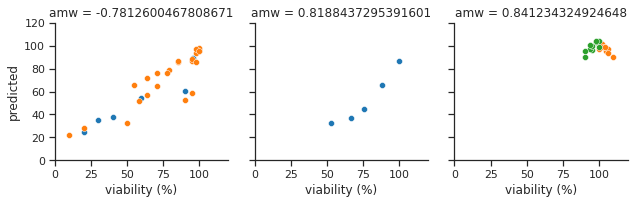

In [31]:
g = sns.FacetGrid(new, col = 'amw', hue='cell line', palette= "tab10"  )
g.map_dataframe(sns.scatterplot, x='viability (%)', y='predicted')
plt.xlim(0, 120)
plt.ylim(0, 120)

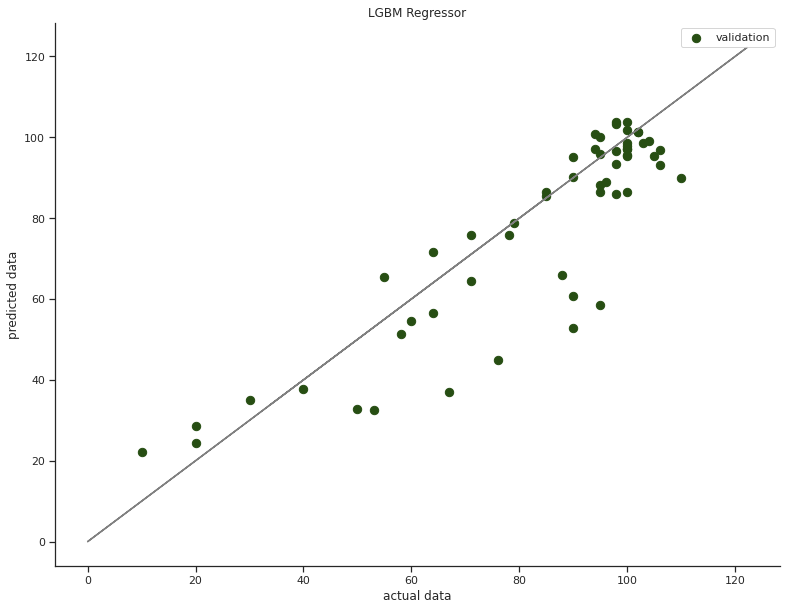

In [32]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
f, ax = plt.subplots(figsize=(13, 10))

# plt.scatter(Y_train, train, color='#DD7059', s=70, label = 'train data')
# plt.scatter(Y_test, test, color='#569FC9',s=70, label = 'test data')
plt.scatter(specific_yval, svalidation, color='#274E13',s=70, label = 'validation')
plt.plot(Y_test, Y_test, color='gray')
plt.title('LGBM Regressor')
plt.xlabel('actual data')
plt.ylabel('predicted data')
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()
# ax.figure.savefig("LGBM_regressor_with_external_data.png",transparent=True)

#feature importance

In [33]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 30.8 MB/s 


In [34]:
import shap

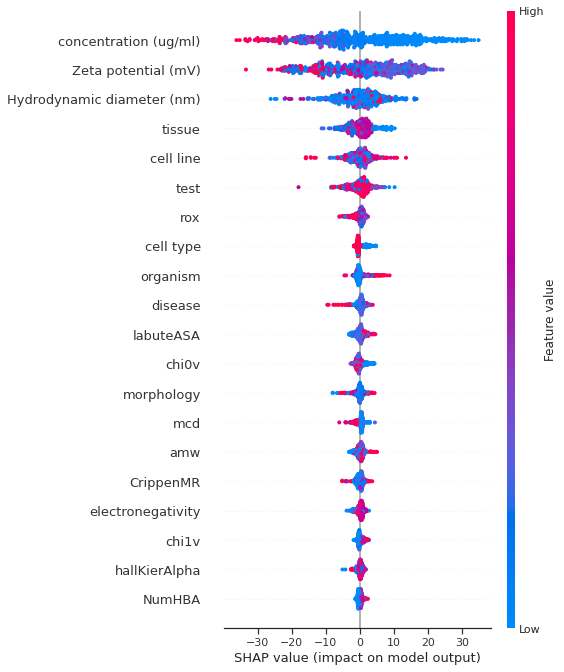

<Figure size 432x288 with 0 Axes>

In [35]:
X_importance = X_test
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance,)
plt.savefig("important_features.png")

In [36]:
plt.savefig('important_features.png')

<Figure size 432x288 with 0 Axes>